In [1]:
import coffea
from coffea import util
import numpy as np
import pandas as pd
import itertools
import os
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")


## analysis categories

In [2]:
# analysis categories #
# ttagcats = ["AT&Pt", "at", "pret", "0t", "1t", ">=1t", "2t", ">=0t"]
ttagcats = ["at", "pret", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

anacats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]
label_dict = {i: label for i, label in enumerate(anacats)}
label_to_int_dict = {label: i for i, label in enumerate(anacats)}

In [3]:
# label_dict

## directories for saving files

In [13]:
save_csv_filename = 'mistag_rate.csv'


directories = [
    '../plots/images/png/mistagRate/2016all',
    '../plots/images/png/mistagRate/2016APV',
    '../plots/images/png/mistagRate/2016',
    '../plots/images/png/mistagRate/2017',
    '../plots/images/png/mistagRate/2018',
    '../plots/images/pdf/mistagRate/2016all',
    '../plots/images/pdf/mistagRate/2016APV',
    '../plots/images/pdf/mistagRate/2016',
    '../plots/images/pdf/mistagRate/2017',
    '../plots/images/pdf/mistagRate/2018',
]

for path in directories:
    if not os.path.exists(path):
        os.makedirs(path)
        




## load coffea files

In [5]:
tagfilename = '_deepak8'
# tagfilename = ''




coffea_dir = '../outputs/'
coffeaFiles = {
    "JetHT":{
        "2016APV": {
            "B": coffea_dir+'JetHT_2016APVB'+tagfilename+'.coffea',
            "C": coffea_dir+'JetHT_2016APVC'+tagfilename+'.coffea',
            "D": coffea_dir+'JetHT_2016APVD'+tagfilename+'.coffea',
            "E": coffea_dir+'JetHT_2016APVE'+tagfilename+'.coffea',
        },
        "2016": {
            "F": coffea_dir+'JetHT_2016F'+tagfilename+'.coffea',
            "G": coffea_dir+'JetHT_2016G'+tagfilename+'.coffea',
            "H": coffea_dir+'JetHT_2016H'+tagfilename+'.coffea',
        },
        "2017": '',
        "2018": ''
    },
    
    "TTbar": {
        "2016APV": {
            "700to1000": coffea_dir+'TTbar_2016APV_700to1000'+tagfilename+'.coffea',
            "1000toInf": coffea_dir+'TTbar_2016APV_1000toInf'+tagfilename+'.coffea',
        },
        "2016": {
            "700to1000": coffea_dir+'TTbar_2016_700to1000'+tagfilename+'.coffea',
            "1000toInf": coffea_dir+'TTbar_2016_1000toInf'+tagfilename+'.coffea',
        },
        "2017": {
            "700to1000": '',
            "1000toInf": '',
        },
        "2018": {
            "700to1000": '',
            "1000toInf": '',
        }
    }
}




## manual jet $p$ bins

In [6]:
# pbins = numerator.axes['jetp'].centers - numerator.axes['jetp'].widths/2
pbins = np.array([ 400.,  500.,  600.,  800., 1000., 1500., 2000., 3000., 7000.])


## scale factors

In [7]:
# https://twiki.cern.ch/twiki/bin/viewauth/CMS/PdmVAnalysisSummaryTable
luminosity = {
    "2016APV": 19800.,
    "2016": 16120., #35920 - 19800
    "2017": 41530.,
    "2018": 59740.
}

ttbar_xs = {}
ttbar_xs["700to1000"] = 831.76 * (0.09210)
ttbar_xs["1000toInf"] = 831.76 * (0.02474)
toptag_sf = 0.9
toptag_kf = 0.7

## calculate mistag rate

In [8]:
IOVs = ['2016APV', '2016']#, '2016']




for IOV in IOVs:
    
    ttbar_700to1000 = util.load(coffeaFiles['TTbar'][IOV]['700to1000'])
    ttbar_1000toInf = util.load(coffeaFiles['TTbar'][IOV]['1000toInf'])
    print('loading', coffeaFiles['TTbar'][IOV]['700to1000'])
    print('loading', coffeaFiles['TTbar'][IOV]['1000toInf'])
    
    ttbar_evts = {}
    ttbar_evts["700to1000"] = ttbar_700to1000['cutflow']['sumw']
    ttbar_evts["1000toInf"] = ttbar_1000toInf['cutflow']['sumw']
    
    ttbar_SF = {}
    ttbar_SF["700to1000"] = luminosity[IOV] * ttbar_xs["700to1000"] * toptag_sf**2 * toptag_kf / ttbar_evts["1000toInf"]
    ttbar_SF["1000toInf"] = luminosity[IOV] * ttbar_xs["1000toInf"] * toptag_sf**2 * toptag_kf / ttbar_evts["1000toInf"]

    save_csv_filename = f'mistag_rate_{IOV}.csv'

    jetht_files = []

    for era, file in coffeaFiles['JetHT'][IOV].items():
        if os.path.isfile(file):
            print('loading', file)
            jetht_files.append(util.load(file))
            
            
    




    mistag_rate_dict = {}
    mistag_rate_dict_all = {}
    mistag_rate_dict["jetp bins"] = pbins
    mistag_rate_dict_all["jetp bins"] = pbins

    for i, label in label_dict.items():

        jetht_numerator   = jetht_files[0]['numerator'][{'anacat':i}].values()
        jetht_denominator = jetht_files[0]['denominator'][{'anacat':i}].values()

        for file in jetht_files[1:]:
            jetht_numerator   += file['numerator'][{'anacat':i}].values()
            jetht_denominator += file['denominator'][{'anacat':i}].values()

        ttbar_numerator   = ttbar_700to1000['numerator'][{'anacat':i}].values() * ttbar_SF['700to1000']
        ttbar_denominator = ttbar_700to1000['denominator'][{'anacat':i}].values() * ttbar_SF['700to1000']

        ttbar_numerator   += ttbar_1000toInf['numerator'][{'anacat':i}].values() * ttbar_SF['1000toInf']
        ttbar_denominator += ttbar_1000toInf['denominator'][{'anacat':i}].values() * ttbar_SF['1000toInf']

        mistag_rate = (jetht_numerator - ttbar_numerator) / (jetht_denominator - ttbar_denominator)
#         mistag_rate = (jetht_numerator - ttbar_numerator) / (jetht_denominator)

        mistag_rate[np.isnan(mistag_rate)] = 0.

        mistag_rate_dict_all[label] = mistag_rate
        
        
        if 'at' in label and 'cen' in label:
            
            # get info for forward and central y regions together (anacat = i+1)
            
            jetht_numerator  += jetht_files[0]['numerator'][{'anacat':i+1}].values()
            jetht_denominator += jetht_files[0]['denominator'][{'anacat':i+1}].values()

            for file in jetht_files[1:]:
                jetht_numerator   += file['numerator'][{'anacat':i+1}].values()
                jetht_denominator += file['denominator'][{'anacat':i+1}].values()

            ttbar_numerator   += ttbar_700to1000['numerator'][{'anacat':i+1}].values() * ttbar_SF['700to1000']
            ttbar_denominator += ttbar_700to1000['denominator'][{'anacat':i+1}].values() * ttbar_SF['700to1000']

            ttbar_numerator   += ttbar_1000toInf['numerator'][{'anacat':i+1}].values() * ttbar_SF['1000toInf']
            ttbar_denominator += ttbar_1000toInf['denominator'][{'anacat':i+1}].values() * ttbar_SF['1000toInf']
            
            
            numerator = jetht_numerator - ttbar_numerator
            denominator = jetht_denominator - ttbar_denominator
            
            
            
            # calculate y inclusive mistag rate
            mistag_rate_yinc = numerator / denominator
            mistag_rate_yinc[np.isnan(mistag_rate_yinc)] = 0.
            mistag_rate_dict[label.replace('at','').replace('cen','')] = mistag_rate_yinc
            
#             mistag_rate_err = np.sqrt(numerator**2*((1/denominator**2)**2 + (numerator/denominator**3)**2))
            
            
            mistag_rate_err = (numerator/denominator) * np.sqrt((1/numerator + 1/denominator))
            
            
            mistag_rate_err[np.isnan(mistag_rate_err)] = 0.
            mistag_rate_dict[label.replace('at','').replace('cen','')+'err'] = mistag_rate_err
            
    df_mistag_all = pd.DataFrame(data=mistag_rate_dict_all)
    df_mistag_all.to_csv(save_csv_filename)
    
    df_mistag = pd.DataFrame(data=mistag_rate_dict)
    df_mistag.to_csv(save_csv_filename.replace('.csv', '_inc.csv'))
    print('saving', save_csv_filename)
    print('saving', save_csv_filename.replace('.csv', '_inc.csv'))

        

loading ../outputs/TTbar_2016APV_700to1000_deepak8.coffea
loading ../outputs/TTbar_2016APV_1000toInf_deepak8.coffea
loading ../outputs/JetHT_2016APVB_deepak8.coffea
loading ../outputs/JetHT_2016APVC_deepak8.coffea
loading ../outputs/JetHT_2016APVD_deepak8.coffea
loading ../outputs/JetHT_2016APVE_deepak8.coffea
saving mistag_rate_2016APV.csv
saving mistag_rate_2016APV_inc.csv
loading ../outputs/TTbar_2016_700to1000_deepak8.coffea
loading ../outputs/TTbar_2016_1000toInf_deepak8.coffea
loading ../outputs/JetHT_2016F_deepak8.coffea
loading ../outputs/JetHT_2016G_deepak8.coffea
loading ../outputs/JetHT_2016H1_deepak8.coffea
loading ../outputs/JetHT_2016H2_deepak8.coffea


/tmp/ipykernel_1750/256625220.py:56: RuntimeWarning: invalid value encountered in divide
  mistag_rate = (jetht_numerator - ttbar_numerator) / (jetht_denominator - ttbar_denominator)
/tmp/ipykernel_1750/256625220.py:88: RuntimeWarning: invalid value encountered in divide
  mistag_rate_yinc = numerator / denominator
/tmp/ipykernel_1750/256625220.py:95: RuntimeWarning: invalid value encountered in divide
  mistag_rate_err = (numerator/denominator) * np.sqrt((1/numerator + 1/denominator))
/tmp/ipykernel_1750/256625220.py:95: RuntimeWarning: divide by zero encountered in divide
  mistag_rate_err = (numerator/denominator) * np.sqrt((1/numerator + 1/denominator))
/tmp/ipykernel_1750/256625220.py:56: RuntimeWarning: invalid value encountered in divide
  mistag_rate = (jetht_numerator - ttbar_numerator) / (jetht_denominator - ttbar_denominator)
/tmp/ipykernel_1750/256625220.py:88: RuntimeWarning: invalid value encountered in divide
  mistag_rate_yinc = numerator / denominator
/tmp/ipykernel_17

saving mistag_rate_2016.csv
saving mistag_rate_2016_inc.csv


## plot mistag rate

In [9]:
IOV = '2016APV'

mistag = pd.read_csv(f'mistag_rate_{IOV}_inc.csv')
tagger = 'DeepAK8 tagger'

# mistag = pd.read_csv(f'old/mistag_rate_{IOV}_inc.csv')
# tagger = 'CMS top tagger'

mistag

,Unnamed: 0,jetp bins,0b,0berr,1b,1berr,2b,2berr
0,0,400.0,0.035431,0.000173,0.117452,0.000673,0.185589,0.003432
1,1,500.0,0.038423,0.000134,0.115567,0.000495,0.189591,0.002577
2,2,600.0,0.045383,0.000124,0.123331,0.000428,0.202317,0.002190
3,3,800.0,0.052414,0.000181,0.128361,0.000573,0.194722,0.002765
4,4,1000.0,0.060245,0.000177,0.131217,0.000519,0.194862,0.002418
5,5,1500.0,0.072060,0.000302,0.139958,0.000856,0.207463,0.004089
6,6,2000.0,0.088853,0.000446,0.148466,0.001224,0.222649,0.006246
7,7,3000.0,0.117321,0.002006,0.160388,0.004962,0.231683,0.025186
8,8,7000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


saving ../plots/images/pdf/mistagRate/2016APV/mistag_deepak8tagger.pdf
saving ../plots/images/png/mistagRate/2016APV/mistag_deepak8tagger.png


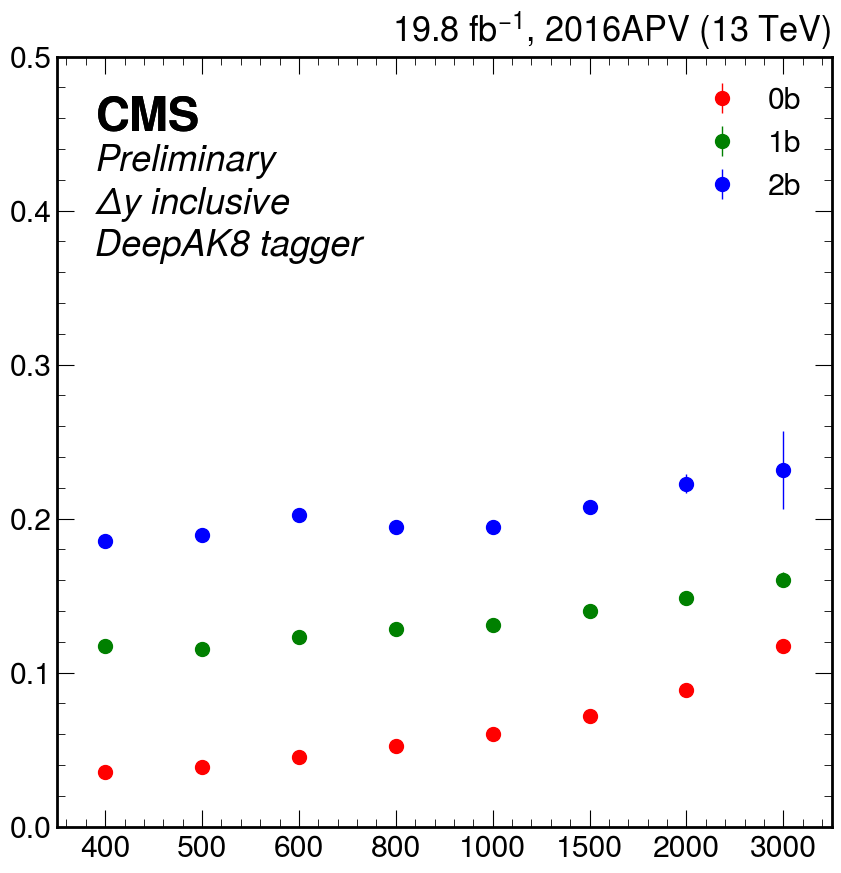

In [14]:
mistag0b = mistag['0b'].values
mistag1b = mistag['1b'].values
mistag2b = mistag['2b'].values

err0b = np.where(mistag['0berr'].values < 0, 0., mistag['0berr'].values)
err1b = np.where(mistag['1berr'].values < 0, 0., mistag['1berr'].values)
err2b = np.where(mistag['2berr'].values < 0, 0., mistag['2berr'].values)

bins = np.arange(len(mistag0b)+1)
pbins = mistag['jetp bins'].values

hep.cms.label('', data=True, lumi=19.8, year=IOV, loc=2)
hep.cms.text('Preliminary'+'\n'
             +r'$\Delta y$ inclusive'+'\n'
             +tagger
             , loc=2)


hep.histplot(mistag0b, bins, yerr=err0b, histtype='errorbar', color='red', markersize=20)
hep.histplot(mistag1b, bins, yerr=err1b, histtype='errorbar', color='green', markersize=20)
hep.histplot(mistag2b, bins, yerr=err2b, histtype='errorbar', color='blue', markersize=20)
plt.legend(['0b', '1b', '2b'])
plt.xticks(bins[:-2]+0.5, [int(b) for b in pbins[:-1]])
plt.ylim(0,0.5)
plt.xlim(0,8)


savefilename = f'../plots/images/pdf/mistagRate/'+IOV+'/mistag_'+tagger.lower().replace('top','').replace(' ','')+'.pdf'

plt.savefig(savefilename)
plt.savefig(savefilename.replace('pdf', 'png'))

print('saving', savefilename)
print('saving', savefilename.replace('pdf', 'png'))

plt.show()
